<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо:

- обучить модель классифицировать комментарии на позитивные и негативные
- построить модель со значением метрики качества F1 не меньше 0.75.

## Загрузка и подготовка данных

In [1]:
# !pip install pymystem3

In [2]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.utils import resample

In [3]:
try:
    df = pd.read_csv('/Users/dariasokolovska/Downloads/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df.duplicated().sum()

0

<AxesSubplot:>

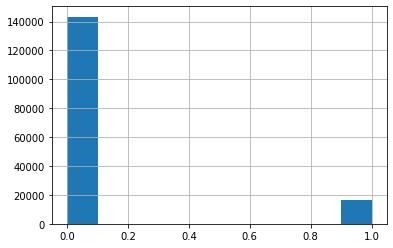

In [7]:
df.toxic.hist()

In [8]:
toxic_messages = df[df.toxic == 1]
not_toxic_messages  = df[df.toxic == 0]
print(toxic_messages.shape)
print(not_toxic_messages.shape)

(16225, 2)
(143346, 2)


По данным выше видно, что классы не сбалансированны. Исправим это выполнив балансировку. Для начала разделим данные на тренировочную и тестовую выборки

In [9]:
train, test = train_test_split(df, test_size = 0.25, random_state = 12345)

In [10]:
toxic_messages = train[train.toxic == 1]
not_toxic_messages  = train[train.toxic == 0]
print(toxic_messages.shape)
print(not_toxic_messages.shape)

(12138, 2)
(107540, 2)


In [11]:
not_toxic_downsample = resample(not_toxic_messages,
             replace=True,
             n_samples=len(toxic_messages),
             random_state=12345)

print(not_toxic_downsample.shape)

(12138, 2)


In [12]:
train_downsampled = pd.concat([toxic_messages, not_toxic_downsample])

In [13]:
toxic_upsample = resample(toxic_messages,
             replace=True,
             n_samples=len(not_toxic_messages),
             random_state=12345)

print(toxic_upsample.shape)

(107540, 2)


In [14]:
train_upsampled = pd.concat([not_toxic_messages, toxic_upsample])

В данных есть разделители строки, заглавные символы, и прочие "помехи", по этому двнные необходимо очистить

In [15]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

train_downsampled['text'] = train_downsampled['text'].apply(cleaning)
test['text'] = test['text'].apply(cleaning)

/tmp/ipykernel_398/2505177120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text'] = test['text'].apply(cleaning)


Так же необходимо выполнить лемматизацию

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.word_tokenize(text)

corpus_train = train_downsampled.text.apply(custom_tokenize)
corpus_test = test.text.apply(custom_tokenize)

The text to be tokenized is a None type. Defaulting to blank string.


In [19]:
#type(corpus[0])

In [21]:
nltk.download('averaged_perceptron_tagger')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    #lemm_list = lemmatizer.lemmatize(text, get_wordnet_pos(text))
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
    #lemm_list = [lemmatizer.lemmatize(w) for w in text]
    return " ".join(lemm_list)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
corpus_train = corpus_train.apply(lemmatize)

In [23]:
corpus_test = corpus_test.apply(lemmatize)

Выполним TFIDF векторизацию

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Разделим данные на обучающую и тестовую выборки

In [27]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

Вывод:

Полученные данные от заказчика чистые, без дубликатов и пропусков.
В предобработке был удален "шум" в виде различных знаков припинания и прочего, выполнены лемматизация и TFIDF векторизация.

Данные готовы для создания моделей

## Обучение моделей

### LogisticRegression

In [22]:
model = LogisticRegression(random_state=12345)
scores =  cross_val_score(model, tf_idf_train, train_downsampled['toxic'], cv = 5, scoring = 'f1')
final_score = scores.mean()
print('F1 = ', "{:.2f}".format(final_score))

F1 =  0.88


### LGBMClassifier

In [26]:
# Подберем гиперпараметры
model = LGBMClassifier(random_state=12345)
parametrs = {'n_estimators': range (36, 46, 1), 'max_depth': range (26, 36, 1)}
grid = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')
grid.fit(tf_idf_train, train_downsampled['toxic'])
grid.best_params_

{'max_depth': 30, 'n_estimators': 45}

In [27]:
# Результат модели с гиперпараметрами
print('F1 = ', "{:.2f}".format(grid.best_score_))

F1 =  0.85


In [28]:
# Обучим модель без гиперпараметров
model = LGBMClassifier(random_state=12345)
scores =  cross_val_score(model, tf_idf_train, train_downsampled['toxic'], cv = 5, scoring = 'f1')
final_score = scores.mean()
print('F1 = ', "{:.2f}".format(final_score))

F1 =  0.88


### RandomForestClassifier

In [ ]:
# Подберем гиперпараметры
model = RandomForestClassifier(random_state=12345)
parametrs = {'n_estimators': range (6, 16, 1), 'min_samples_leaf': range (1, 11, 1)}
grid = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')
grid.fit(tf_idf_train, target_train)
grid.best_params_

In [ ]:
# Результат модели с гиперпараметрами
print('F1 = ', "{:.2f}".format(grid.best_score_))

In [ ]:
# Обучим модель без гиперпараметров
model = RandomForestClassifier(random_state = 12345)
scores =  cross_val_score(model, tf_idf_train, target_train, cv = 5, scoring = 'f1')
final_score = scores.mean()
print('F1 = ', "{:.2f}".format(final_score))

### Проверка на тестовой выборке

In [33]:
model = LGBMClassifier(random_state=12345)
model.fit(tf_idf_train, train_downsampled['toxic'])
predictions = model.predict(tf_idf_test)
print('F1 = ', "{:.2f}".format(f1_score(predictions, test['toxic'])))

F1 =  0.69


In [30]:
model = LogisticRegression(random_state = 12345)
model.fit(tf_idf_train, train_downsampled['toxic'])
predictions = model.predict(tf_idf_test)
print('F1 = ', "{:.2f}".format(f1_score(predictions, test['toxic'])))

F1 =  0.76


## Вывод

Лучший результат показала модель логистической регрессии с значением f1 - 0.75.